In [32]:
from typing import Dict, List
from ddnn.nn import *
from ddnn.data import *
from ddnn.validation import *

In [33]:
net = NeuralNetwork(
    [
        LinearLayer((8, 16)),
        ActivationFunction(),
        LinearLayer((16, 16)),
        ActivationFunction(),
        LinearLayer((16, 2)),
    ]
)
estimator = Estimator(net) # fix to work without anything
grid = {}
grid["layers"] = [
    [(4, "ReLU"), (1, "logistic")],
]
grid["learning_rate"] = [0.5]
grid["momentum_coefficient"] = [0.9]
grid["optimizer"] = ["SGD"]
grid["loss"] = ["MSE"]
grid["l2_coefficient"] = [1e-4, 1e-5]
grid["batchsize"] = [-1, 64]
grid["weight_initializer"] = ["random_uniform", "random_normal"]
# grid['fan_mode'] = ['fan_in', 'fan_out']
selector = GridSearch(estimator, grid, 123)

In [34]:
# data = read_ML_cup("train")
data = read_monks(1, "train")
data = onehot_encoding(data=data)

In [35]:
logger = Logger(estimator, ["MSE", "binary_accuracy"], every=5)

In [36]:
selector.k_fold(
    data,
    5,
    n_epochs=2000,
    loss_list=["MSE"],
    early_stopping=(10, 10),
    seed=123,
    on_fold_change=logger.update_fold,
    on_hp_change=logger.update_hp,
    training_callback=logger,
);

{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.0001, 'batchsize': -1, 'weight_initializer': 'random_uniform'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.0001, 'batchsize': -1, 'weight_initializer': 'random_normal'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.0001, 'batchsize': 64, 'weight_initializer': 'random_uniform'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.0001, 'batchsize': 64, 'weight_initializer': 'random_normal'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 1e-05, 

In [37]:
# save to file
import json
with open("trial.json", "w") as fp:
    json.dump(logger._scores, fp)

In [99]:
# open with pandas
import pandas as pd
df = pd.json_normalize(logger._scores)
df["hp.layers"] = df["hp.layers"].astype(str) # convert layers to str repr

In [100]:
from ipywidgets.widgets import interact_manual, interact
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

interactive(children=(Dropdown(description='loss', options=('MSE', 'binary_accuracy'), value='MSE'), Dropdown(…

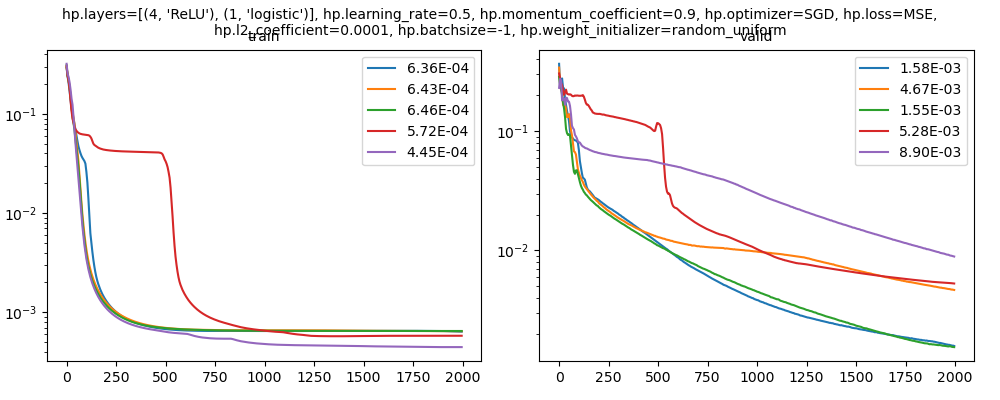

In [110]:
%matplotlib ipympl

# select loss, hyper get 2 plots one with train one with valid
fig, axs = plt.subplots(1,2, figsize=(10,4))

params = {
    k: df[k].unique() 
    for k in df.columns[df.columns.str.startswith("hp.")]
}

@interact(
    loss = logger._losses,
    **params
)
def plot_results(loss, **kwargs):
    
    row_selection = pd.Series([True]*df.shape[0])
    for k,v in kwargs.items():
        row_selection &= (df[k] == v)
    rows = df[row_selection]

    fig.suptitle(", ".join([f"{k}={v}" for k,v in kwargs.items()]), wrap=True, fontsize=10)
    fig.tight_layout()
    for where, ax in zip(["train", "valid"], axs):
        col_selection = rows.columns.str.endswith(f"{where}.{loss}")
        data = rows[rows.columns[col_selection]]

        ys = [y for y in data.values][0]
        if loss != "binary_accuracy":
            bests = [min(y) for y in ys]
            form = "{:.2E}"
            logplot = True
        else:
            bests = [max(y) for y in ys]
            form = "{:.2}"
            logplot = False

        ax.clear()
        ax.set_title(where, fontsize=10)
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*logger._every))
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        for y,best in zip(ys, bests):
            ax.plot(y, label=f"{form.format(best)}")
        ax.legend()

interactive(children=(Dropdown(description='loss', options=('MSE', 'binary_accuracy'), value='MSE'), Dropdown(…

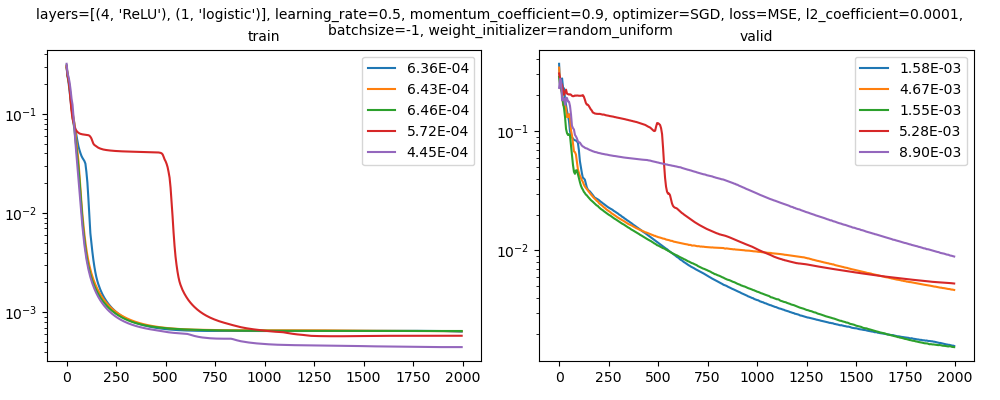

In [40]:
%matplotlib ipympl

# select loss, hyper get 2 plots one with train one with valid

hps = [x["hp"] for x in logger._scores]
fig, axs = plt.subplots(1,2, figsize=(10,4))

@interact(
    loss = logger._losses,
    hyper = df.columns
)
def plot_results(loss, hyper):
    fig.suptitle(", ".join([f"{k}={v}" for k,v in hyper.items()]), wrap=True, fontsize=10)
    fig.tight_layout()
    for where, ax in zip(["train", "valid"], axs):
        ys = [y[where][loss] for y in logger._scores[hps.index(hyper)]["folds"].values()]
        if loss != "binary_accuracy":
            bests = [min(y) for y in ys]
            form = "{:.2E}"
            logplot = True
        else:
            bests = [max(y) for y in ys]
            form = "{:.2}"
            logplot = False

        ax.clear()
        ax.set_title(where, fontsize=10)
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*logger._every))
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        for y,best in zip(ys, bests):
            ax.plot(y, label=f"{form.format(best)}")
        ax.legend()